# Computational exercise for open chain kinematics

We assume a simplified and thus static analysis of the leg structure on a robot. We ca retrieve a forward kinematics expression and a differential kinematics expression (Jacobian). With the differential kinematics, we can determine the actuator forces in the system when external forces are specified:

$\tau = J^Tf$

We have an open chain with 3 DOFs whose geometry is defined by three link length $L_1, L_2$ and $L_3$.


.

.

<figure>
    <img src="leg.png" width="400">
    <figcaption>**Depiction of the leg structure.**</figcaption>
</figure>

For this purpose we use the already available functions from Northwestern University - Modern Robotics. This way we do not need to bother about the structure of the code, but can base our computations solely on the definition of **screws** that model our joints. We will derive both screw expressions - in **space frame** and **body frame** description.

### Importing a few helpful libraries and the code from Modern Robotics

In [1]:
# package for many numerical functions
import numpy as np 

# package for plotting data
import matplotlib.pyplot as plt  
from mpl_toolkits.mplot3d import Axes3D

# functions from Modern robotics
import modern_robotics_code as mrc

### Setting the geometry of the chain

In [2]:
L1 = 0.1; L2 = 0.5; L3 = 0.5

### In any case we will need the screws of the joints and they are thus defined

In [3]:
q_list_s = [np.array([0,0,0]),np.array([0,L1,0]),np.array([0,L1+L2,0])]
q_list_b = [np.array([0,-(L1+L2),L3]),np.array([0,-L2,L3]),np.array([0,0,L3])]

# Mind that by defining omega, you also define in which direction you have positive rotation!      
# In this case, both omegas are the same
w_list = [np.array([0,0,1]),np.array([1,0,0]),np.array([1,0,0])]

S_list = [] 
for q,w in zip(q_list_s,w_list):
    S_list.append(np.append(w,np.cross(-w,q)))
S_list = np.array(S_list).T

B_list = []
for q,w in zip(q_list_b,w_list):
    B_list.append(np.append(w,np.cross(-w,q)))                                            
B_list = np.array(B_list).T

In [4]:
S_list

array([[ 0. ,  1. ,  1. ],
       [ 0. ,  0. ,  0. ],
       [ 1. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ],
       [ 0. , -0.1, -0.6]])

In [5]:
B_list

array([[ 0. ,  1. ,  1. ],
       [ 0. ,  0. ,  0. ],
       [ 1. ,  0. ,  0. ],
       [-0.6,  0. ,  0. ],
       [-0. ,  0.5,  0.5],
       [-0. ,  0.5, -0. ]])

### For the forward kinematics we also need the zero configuration **M**

.


<figure>
    <img src="zero_conf.png" width="250">
    <figcaption>**Zero configuration of the end-effector.**</figcaption>
</figure>

In [6]:
# Given in space frame
M = np.array([[1,0,0,0],
              [0,1,0,L1+L2],
              [0,0,1,-L3],
              [0,0,0,1]])

## Computation of a certain trajectory of the end-effector
Let's assume that we move the tilt joint with a constant speed and the inner leg joint first upward (positive) and then downward (negative) (cosine function):

In [7]:
dt = 0.1
t = 0
te = 2

rot = 3.5*np.pi/2/te

location = []
while t < te:
    
    theta1 = -0.6*t/te; theta2 = -0.1*np.cos(rot*t)
    
    T = mrc.FKinSpace(M,S_list,[theta1,theta2,0])
    location.append(T[0:3,3])
    
    t += dt

location = np.array(location)

### Plotting the trajectory

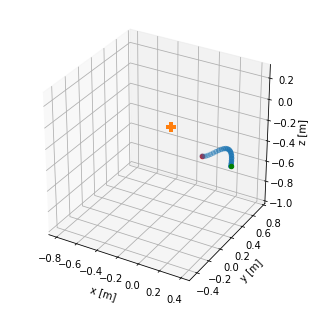

In [8]:
fig1 = plt.figure()
ax = Axes3D(fig1)
ax = fig1.gca(projection='3d')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_aspect('equal')

# plotting trajectory points
ax.scatter(location[:,0],location[:,1],location[:,2])

# plotting start and end position
ax.scatter(location[0,0],location[0,1],location[0,2],color='r')
ax.scatter(location[-1,0],location[-1,1],location[-1,2],color='g')

# plotting initial frame
ax.scatter(0,0,0,marker="+",linewidth=10)

# this part is used to have a defined plot around our trajectory
X = np.array((-0.6,0.2))
Y = np.array((-0.5,0.8))
Z = np.array((-0.7,0))

max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0

mid_x = (X.max()+X.min()) * 0.5
mid_y = (Y.max()+Y.min()) * 0.5
mid_z = (Z.max()+Z.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

plt.show()

## Computing singularity points and determining the actuator forces
We use the **body frame** description, since the force is also applied in that frame.

In [9]:
samples = 50

# definition of the workrange. We will opress theta1, since it only moves in the plane
#theta1_r = np.linspace(-np.pi/2,np.pi/2,samples)
theta2_r = np.linspace(-np.pi/6,np.pi/6,samples)
theta3_r = np.linspace(-np.pi/6,np.pi/2,samples)

# defining the rotational and translational part of the wrench at the end-effector
m_e = np.array([0,0,0])
f_e = np.array([0,0,9.81e3])

condJ = np.zeros((samples,samples))
tau2 = np.zeros((samples,samples))
tau3 = np.zeros((samples,samples))

i = 0
for theta2 in theta2_r:
    j = 0
    for theta3 in theta3_r:

        # We need to accout for the frame rotation at the end-effector, so that F_e also changes direction
        T = mrc.FKinBody(M,B_list,[0,theta2,theta3])
        R = T[0:3,0:3]
        F_e = np.append(m_e,np.matmul(R.T,f_e))

        J = mrc.JacobianBody(B_list,[0,theta2,theta3])

        condJ[i,j] = np.linalg.cond(np.matmul(J.T,J))
        tau2[i,j] = np.matmul(J.T,F_e)[1]
        tau3[i,j] = np.matmul(J.T,F_e)[2]

        j += 1
    i += 1


/home/dfki.uni-bremen.de/cstoeffler/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


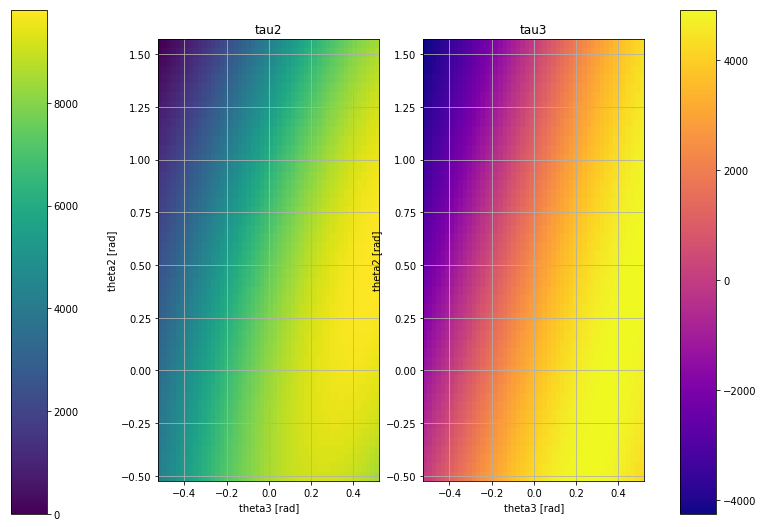

In [10]:
fig2, axarr = plt.subplots(1,2,figsize=(10,10))

im1 = axarr[0].imshow(tau2,cmap='viridis',interpolation='none',
     extent=[-np.pi/6,np.pi/6,-np.pi/6,np.pi/2])

im2 = axarr[1].imshow(tau3,cmap='plasma',interpolation='none',
     extent=[-np.pi/6,np.pi/6,-np.pi/6,np.pi/2])

axarr[0].set_title('tau2')
axarr[1].set_title('tau3')

axarr[0].set_ylabel('theta2 [rad]')
axarr[0].set_xlabel('theta3 [rad]')

axarr[1].set_ylabel('theta2 [rad]')
axarr[1].set_xlabel('theta3 [rad]')

axarr[0].grid()
axarr[1].grid()


fig2.subplots_adjust(right=0.8)
cbar_ax1 = fig2.add_axes([-0.08, 0.15, 0.05, 0.7])
fig2.colorbar(im1, cax=cbar_ax1)

fig2.subplots_adjust(right=0.8)
cbar_ax2 = fig2.add_axes([0.85, 0.15, 0.05, 0.7])
fig2.colorbar(im2, cax=cbar_ax2)

fig2.show()
#fig2.savefig('./results/transmission'.eps', format='eps', dpi=500)

/home/dfki.uni-bremen.de/cstoeffler/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


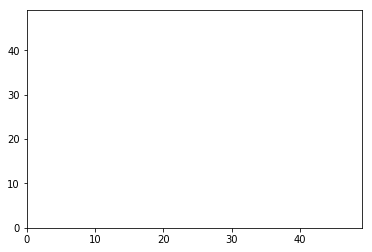

In [11]:
plt.contour(tau2,levels=[0])

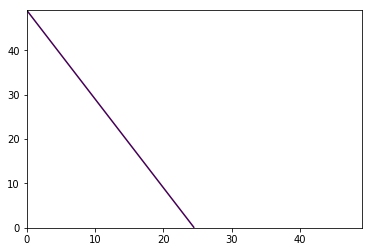

In [12]:
plt.contour(tau3,levels=[0])

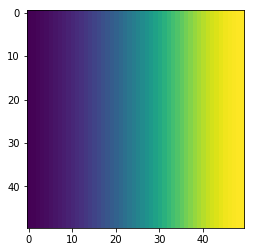

In [13]:
plt.imshow(condJ)